In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf,pacf
from datetime import datetime,timedelta
from time import time

In [2]:
df = pd.read_csv('catfish.csv',parse_dates=['Date'],index_col=0,squeeze=True)
df.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Name: Total, dtype: int64

In [3]:
start_data = datetime(2000,1,1)
end_data   = datetime(2004,1,1)
df_data = df[start_data:end_data]
df_data.head()

Date
2000-01-01    25412
2000-02-01    25354
2000-03-01    29161
2000-04-01    24924
2000-05-01    24763
Name: Total, dtype: int64

In [4]:
df_data = df_data.asfreq(pd.infer_freq(df_data.index))
df_data.head()

Date
2000-01-01    25412
2000-02-01    25354
2000-03-01    29161
2000-04-01    24924
2000-05-01    24763
Freq: MS, Name: Total, dtype: int64

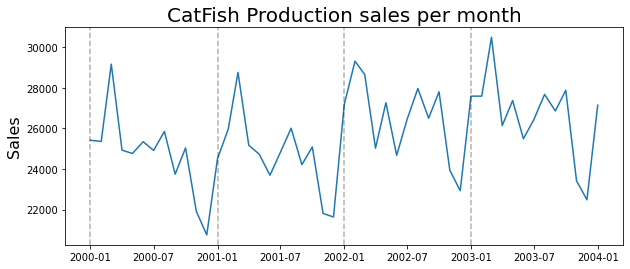

In [5]:
plt.figure(figsize=(10,4))
plt.plot(df_data)
plt.title('CatFish Production sales per month',fontsize=20)
plt.ylabel('Sales',fontsize=16)
for year in range(start_data.year,end_data.year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.3)

In [6]:
first_diff = df_data.diff()[1:]
first_diff.head()

Date
2000-02-01     -58.0
2000-03-01    3807.0
2000-04-01   -4237.0
2000-05-01    -161.0
2000-06-01     579.0
Freq: MS, Name: Total, dtype: float64

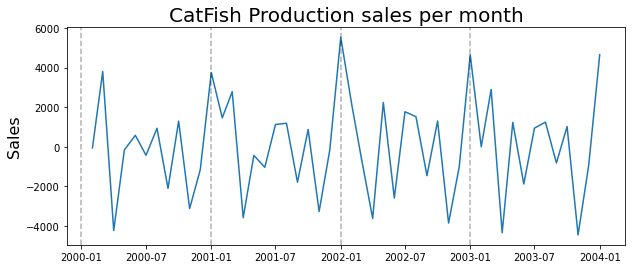

In [7]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('CatFish Production sales per month',fontsize=20)
plt.ylabel('Sales',fontsize=16)
for year in range(start_data.year,end_data.year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.3)

## ACF

C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<BarContainer object of 20 artists>

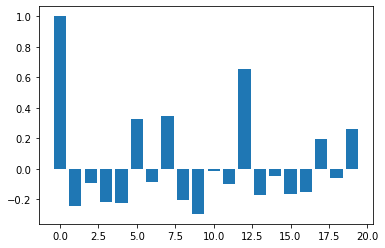

In [8]:
acf_vals = acf(first_diff)
plt.bar(range(20),acf_vals[:20])

## PACF

<BarContainer object of 11 artists>

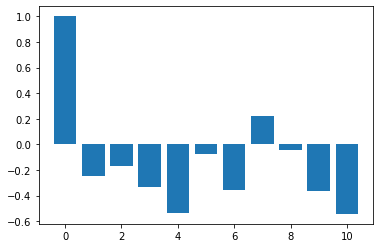

In [9]:
pacf_vals = pacf(first_diff,nlags=10)
plt.bar(range(11),pacf_vals[:11])

#### we build our AR(4)MA(1) model

In [10]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data  = first_diff[train_end+ timedelta(days=1):test_end]

In [11]:
model = ARMA(first_diff,order=(4,1))
start = time()
model_fit = model.fit()
end = time()
print("The model took {} amount of time".format(end-start))

C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


The model took 0.19127941131591797 amount of time


In [12]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Total   No. Observations:                   48
Model:                     ARMA(4, 1)   Log Likelihood                -431.046
Method:                       css-mle   S.D. of innovations           1882.645
Date:                Fri, 20 Nov 2020   AIC                            876.092
Time:                        20:16:48   BIC                            889.190
Sample:                    02-01-2000   HQIC                           881.041
                         - 01-01-2004                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.9290    116.419      0.077      0.939    -219.249     237.107
ar.L1.Total    -0.8019      0.206     -3.887      0.000      -1.206      -0.398
ar.L2.Total    -0.4528      0.157     -2.877    

Our ARMA(4,1) equation becomes

$\hat{y_t} = -0.8y_{t-1} - 0.45y_{t-2} - 0.58y_{t-3} - 0.61y_{t-4} + 0.43\varepsilon_{t-1}$

In [13]:
pred_start_date = test_data.index[0]
pred_end_date  = test_data.index[-1]

In [14]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

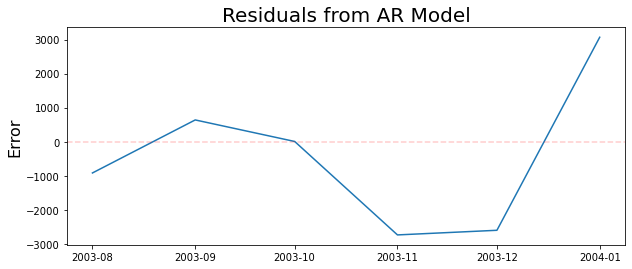

In [15]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

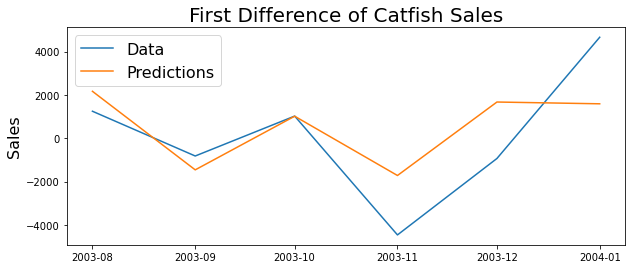

In [16]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [17]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2039.916591896437
